# src_18

This is a rerun of `src/17/main.jl`, but after the recent improvements implemented to LBMengine.jl. In particular, I'm now using a TRT model, with PSM for the particle-fluid interactions.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
src_n = 18
dir = f'../data.lbm/{src_n}/'
# dir = f'../src/{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Particle

In [4]:
particleDf = pd.read_csv(dir+"particlesTrj.csv")
particleRadius = 1;

# Fluid

In [5]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

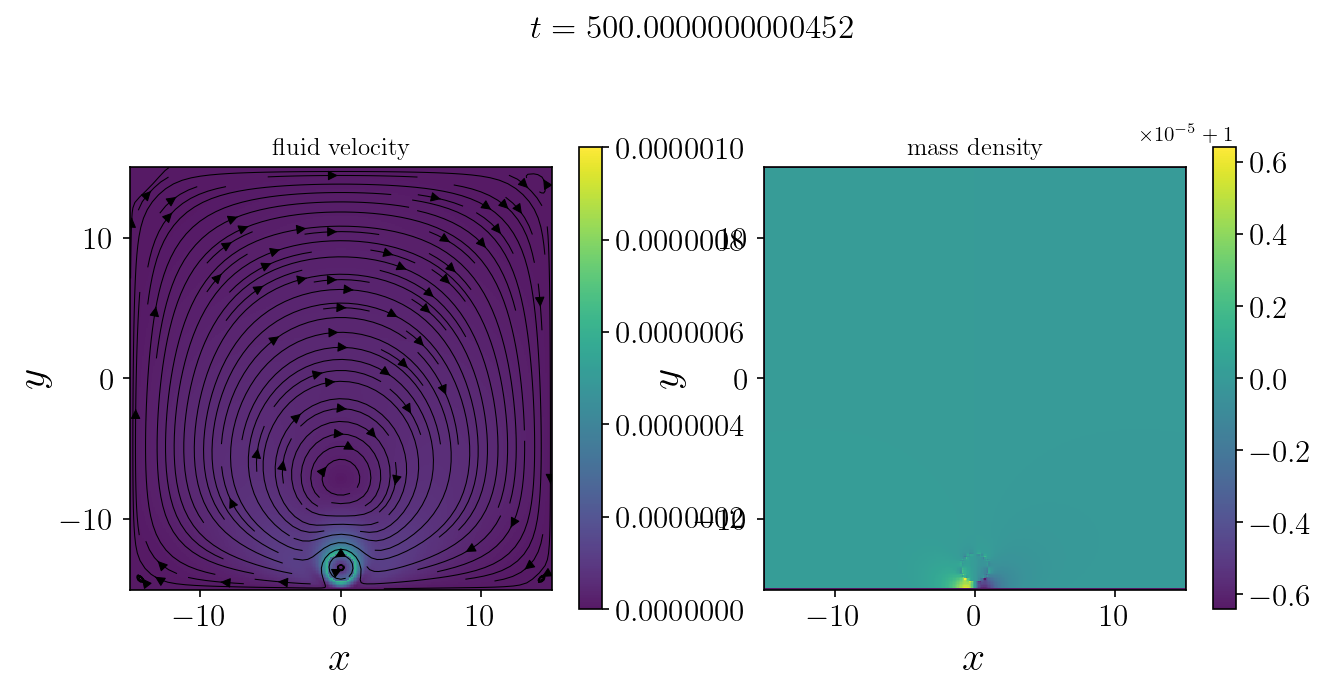

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Add a title for the whole figure
fig.suptitle(f"$t = {fluidDf.time.values[0]}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

axes[0].streamplot(X, Y, 
    fluidDf.fluidVelocity_x.unstack().values.transpose(),
    fluidDf.fluidVelocity_y.unstack().values.transpose(),
    density=1.5, linewidth=0.5, color="black",
)

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    vmax=1e-6,
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 0").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(len(axes)):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

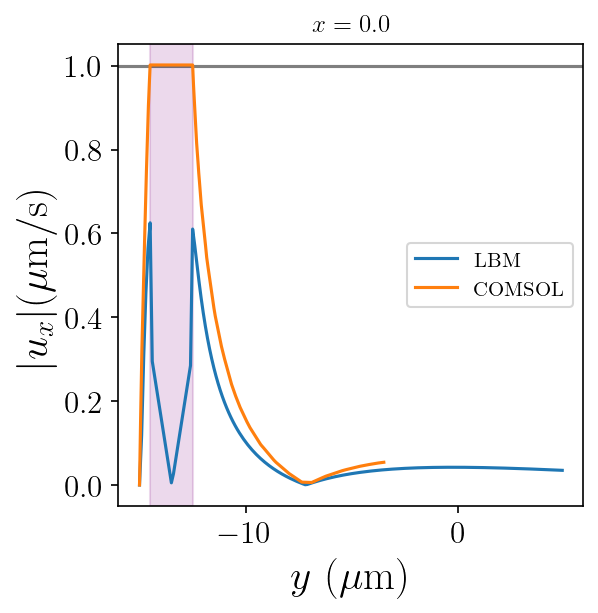

In [7]:
comsolResults = pd.read_csv('../data.lbm/VelocityProfile.csv', delimiter=',')

# encuentro el primer id_x tal que coordinate_x sea mayor o igual a la posición de la partícula
position_x = particleDf.query(f'tick == {ticks[-1]}').position_x.values[0]
position_y = particleDf.query(f'tick == {ticks[-1]}').position_y.values[0]
id = fluidDf.query(f"coordinate_x >= {position_x}").reset_index().iloc[0].filter(["id_x"]).values[0]

# ploteo v_x(y, x = 0)
v_x = fluidDf.loc[id].filter(["coordinate_y", "fluidVelocity_x"])

wallPosition = -15
plt.axhline(1, color = 'k', alpha=0.5) # tangential velocity (μm/ms)
plt.axvspan(position_y-particleRadius, position_y+particleRadius, color='purple', alpha=0.15)  # Shade the sphere

plt.plot(v_x.query('coordinate_y < 5').coordinate_y, 1e6*abs(v_x.query('coordinate_y < 5').fluidVelocity_x), label = "LBM") 
plt.plot(comsolResults.coordinate_y - 15, comsolResults.fluidVelocity_x, label = "COMSOL") 
plt.xlabel("$y ~ (\\mu \\mathrm{m})$")
plt.ylabel("$|u_x| (\\mu \\mathrm{m} / \\mathrm{s})$")
plt.title(f"$x = {fluidDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$")
# plt.axvline(wallPosition, color = "k")
plt.legend()

plt.show()

In [8]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

avgFluidSpeed = [
    avgSpeed(pd.read_csv(dir + f"fluidTrj_{tick}.csv"))
for tick in ticks]
time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks]

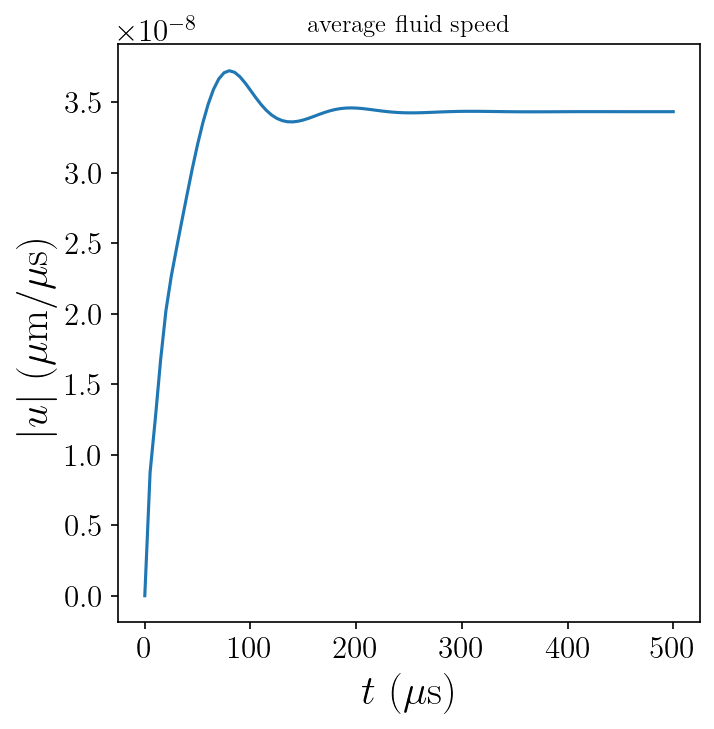

In [9]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_title("average fluid speed")
ax.set_xlabel("$t~(\\mu \\mathrm{s})$")
ax.set_ylabel("$|u|~(\\mu \\mathrm{m}/\\mu \\mathrm{s})$")

plt.show()

# Stress tensor

In [10]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

tick   time  coordinate_x  coordinate_y  component_xx  \
id_x id_y                                                          
1    1     5000  500.0         -15.0         -15.0          -0.0   
     2     5000  500.0         -15.0         -14.9          -0.0   
     3     5000  500.0         -15.0         -14.8          -0.0   
     4     5000  500.0         -15.0         -14.7          -0.0   
     5     5000  500.0         -15.0         -14.6          -0.0   
...         ...    ...           ...           ...           ...   
301  297   5000  500.0          15.0          14.6          -0.0   
     298   5000  500.0          15.0          14.7          -0.0   
     299   5000  500.0          15.0          14.8          -0.0   
     300   5000  500.0          15.0          14.9          -0.0   
     301   5000  500.0          15.0          15.0          -0.0   

           component_yx  component_xy  component_yy  
id_x id_y                                            
1    1             -0.0          -0.0          -0.0  
     2             -0.0          -0.0          -0.0  
     3             -0.0          -0.0          -0.0  
     4             -0.0          -0.0          -0.0  
     5             -0.0          -0.0          -0.0  
...                 ...           ...           ...  
301  297           -0.0          -0.0          -0.0  
     298           -0.0          -0.0          -0.0  
     299           -0.0          -0.0          -0.0  
     300           -0.0          -0.0          -0.0  
     301           -0.0          -0.0          -0.0  

[90601 rows x 8 columns]

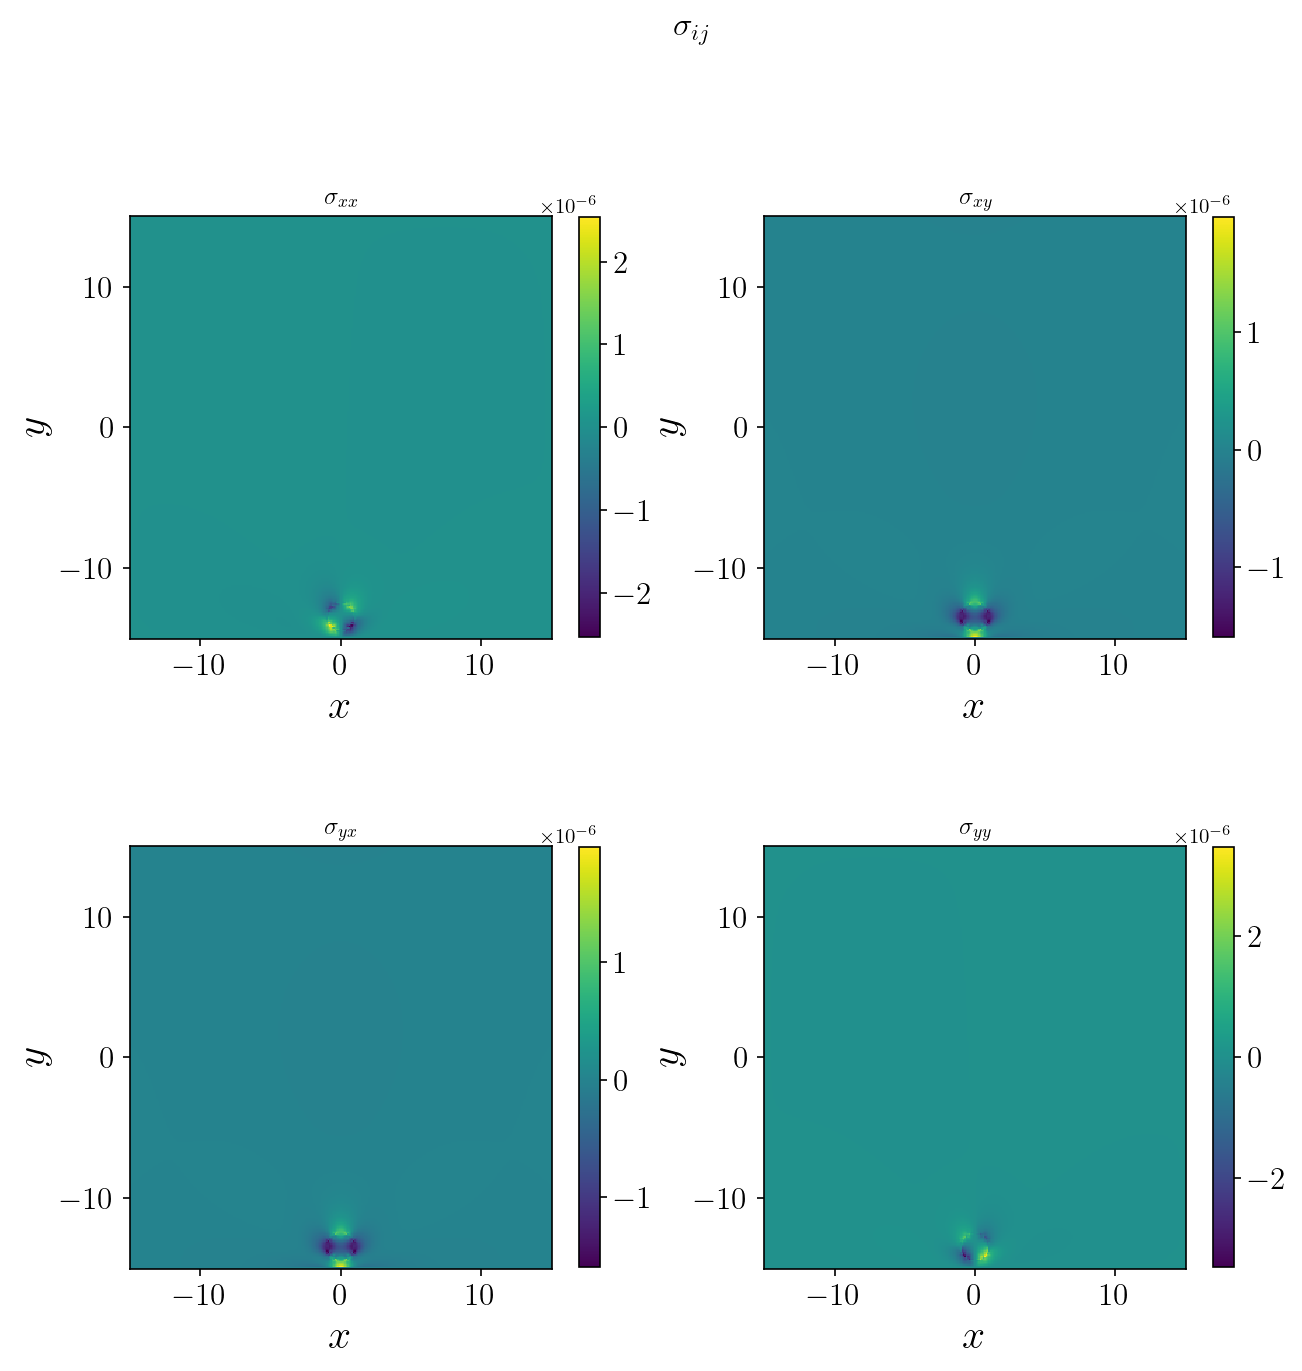

In [11]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()